In [1]:
#load packages
import os, sys, cv2, re, itertools,time
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
from PyQt5 import QtWidgets, QtGui
from PyQt5.uic import loadUi
from tensorflow import keras
from tensorflow.keras import layers
from keras.preprocessing import image
from keras.utils import to_categorical
from keras.utils import plot_model
from sklearn import svm
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder

In [2]:
from customised_functions import * #import my customised functions

In [3]:
#Data preparation

##load dataframe prepared 
train_folder = "C:/Users/folia/metar_project/images/filtered/filtered_train_cropped"
df = pd.read_excel("C:/Users/folia/metar_project/images/filtered/filtered_train_cropped/filtered_train.xlsx")
df = df.sample(frac=1) #random shuffle for dataframe, just to cut off smilarities between "windows" and let model learn more complex patterns

#First, visualise ROI and non-ROI images in 3D plot to see if they are seperatable.
img_list_train = []       #create a list of image arrays

#Read images into an array, and calculate mean value of every channel of each photo
for name in df['window_name']:
    #Read images
    temp = cv2.imread(os.path.join(train_folder, name))
    img_list_train.append(temp)
    
img_list_train = np.array(img_list_train,dtype="float32")/255.0    
del temp

In [4]:
#SVM model for binary image classification

#Prepare data source
L = img_list_train.shape[0]
img_list_train_svm = img_list_train.reshape(L,-1) #One shape dimension can be -1. This is to flatten images

#Build and train SVM model. Polynomil kernel functions has the best performence on this dataset.
svm_poly = svm.SVC(kernel='poly')
svm_poly.fit(img_list_train_svm, df['is_ROI'])

SVC(kernel='poly')

In [5]:
#Examinate model performence

#Accuracy
svm_poly.score(img_list_train_svm,df['is_ROI'])  #Accuracy 92%

#Confusion Matrix
classes = ["Y","N"]
df["is_ROI_pred"] = svm_poly.predict(img_list_train_svm)
cm = confusion_matrix(df['is_ROI'],df["is_ROI_pred"],labels =classes) #set order of classes Y -> N for readibility
print('Confusion Matrix of SVM', "\n",cm)

Confusion Matrix of SVM 
 [[229  18]
 [  7  86]]


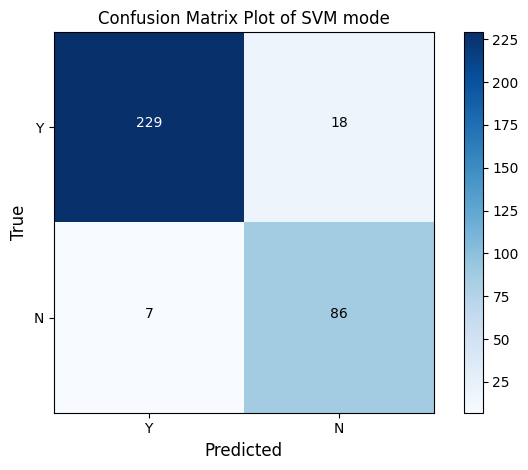

In [6]:
#Visualise comfusion matrix in heatmap form
#Add data
plt.imshow(cm, interpolation = "nearest", cmap = plt.cm.Blues)

#Add legend
plt.title("Confusion Matrix Plot of SVM mode")
plt.colorbar()
ticks = np.arange(len(classes)) #take unique values, and then set sequence number
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j]),horizontalalignment="center",
                 color="white" if cm[i, j] >  cm.max()/2 else "black")
                 #plt.text() in col-row order, inverse of cm, thus input j, i    
plt.ylabel('True',fontsize=12)
plt.xlabel('Predicted',fontsize=12)

#Plot out
plt.tight_layout()

In [7]:
#Examinate the model trained on test data

#Folder path
df_test = pd.read_excel("C:/Users/folia/metar_project/images/filtered/filtered_test_cropped/filtered_test.xlsx")
test_folder = "C:/Users/folia/metar_project/images/filtered/filtered_test_cropped"

#Load images
img_list_test = []
for name in df_test['window_name']:
    temp = cv2.imread(os.path.join(test_folder, name))
    img_list_test.append(temp)

img_list_test = np.array(img_list_test,dtype="float32")/255.0    
del temp

#Flatten data
L = img_list_test.shape[0]
img_list_test_svm = img_list_test.reshape(L,-1)

#Check accuracy
accuracy = svm_poly.score(img_list_test_svm,df_test["is_ROI"]).round(2)
print(f"The accuracy of SVM classification on test data is {accuracy*100} %")

The accuracy of SVM classification on test data is 76.0 %


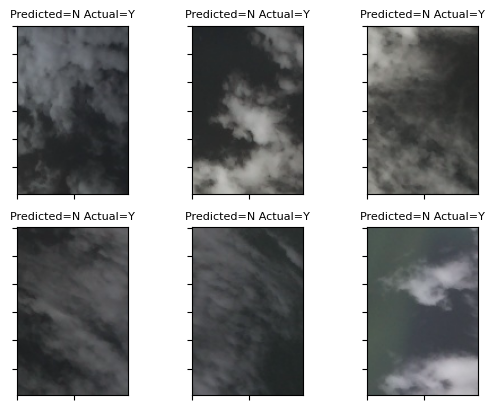

'\nOn test dataset, the accuracy is approximately 76%.\nFirst, check the original data. \nTest label list has 57% of Y, 43% of N, by which we can say that the SVM model perform well over naive guess,\nand orginal Y/N distribution seems has no effect on prediction. \nHowever, it takes too long on predicting computation.\n\nAfter examining the images below, two interim conclusion were made, as following.\n1. It seems that the SVM model performs well on pattern recognition, some falsely marked (by me) were pick out.\n2. Edge of clouds is likely to be falsely recognised (Ex: the first image on left upper corner).\n'

In [8]:
#Make predictions and inspect results

#Make prediction
start_time = time.time()
df_test['is_ROI_pred'] = svm_poly.predict(img_list_test_svm)
end_time = time.time()
t_diff1 = end_time - start_time 

#Check images of unmatched predictions
mask = df_test['is_ROI'] != df_test['is_ROI_pred']
temp = df_test[mask] #prefer use a temporarily instance to simplify coding
index = temp.index #index of df was shuffled, thus need an extra index

for i in range(6):
    img = cv2.imread(os.path.join(test_folder,temp['window_name'][index[i]]))
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title("Predicted=" + temp['is_ROI_pred'][index[i]] + " Actual=" + temp['is_ROI'][index[i]],fontsize=8)
    plt.xticks(visible = False)
    plt.yticks(visible = False)
plt.show()
del temp
'''
On test dataset, the accuracy is approximately 76%.
First, check the original data. 
Test label list has 57% of Y, 43% of N, by which we can say that the SVM model perform well over naive guess,
and orginal Y/N distribution seems has no effect on prediction. 
However, it takes too long on predicting computation.

After examining the images below, two interim conclusion were made, as following.
1. It seems that the SVM model performs well on pattern recognition, some falsely marked (by me) were pick out.
2. Edge of clouds is likely to be falsely recognised (Ex: the first image on left upper corner).
'''

In [9]:
#prepare features
##This model will have total 5 input features, image array, relative humidity, air pressure, hour, if ROI(predicted)
##Lux value is also a candidate, but there are not enough observations, and thus not adapted for now.

#Preprecessing of 3 features
df['rh'] = rh_calculator(df['t_amb'],df['t_dew']) #calculate relative humidity
df['qnh_normalised'] = normalise_1D_array(df['qnh']) #Normalise qnh value to avoid bias
h_factor = (df['hh_z']-4).abs() #GMT time to CST +8, then minus 12, and take abs. value to represent light intensity. -12 on assuming 12pm is the brightest hour.

#Convert h_factor and is_ROI to categorical variable
h_factor = to_categorical(h_factor,num_classes=12) #turn numeric value to one-hot code

label_encoder = LabelEncoder()
is_ROI = label_encoder.fit_transform(df["is_ROI_pred"]) #turn str to label
is_ROI = to_categorical(is_ROI,num_classes=2) #then turn label to one_hot code

In [10]:
#Build a multivariate CNN

#1.Image layers
imgs = keras.Input(shape=(149,99,3),name = "img_input")
img_layers = layers.Conv2D(filters = 32, kernel_size = 5, activation = "relu")(imgs)
img_layers = layers.MaxPooling2D(pool_size=3)(img_layers)
img_layers = layers.Conv2D(filters = 64, kernel_size = 5, activation = "relu")(img_layers)
img_layers = layers.MaxPooling2D(pool_size=3)(img_layers)
img_flatten = layers.Flatten()(img_layers)  #this section takes images(3D array) to 1D array, which is to be concatenated with 4 other variables.

# 2.Other input layers
rh = keras.Input(shape=(1,),name='rh')
qnh = keras.Input(shape=(1,),name='qnh')
hour = keras.Input(shape=(12,),name='h_factor')
roi = keras.Input(shape=(2),name="is_ROI")

#3.Concatenate all input layers
features = layers.concatenate([img_flatten,rh,qnh,hour,roi])

#4.Build hidden layers for 1D tensors
dense_layers = layers.Dense(units=256, activation="relu")(features)
outputs = layers.Dense(1,activation = "linear")(dense_layers) #for regression purpose, adapt "linear" activation method

#5.Connect inputs and outputs, then compile
model3 = keras.Model(inputs = [imgs,rh,qnh,hour,roi], outputs = outputs)
model3.summary()
model3.compile(loss = "mean_squared_error", optimizer = "adam")

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img_input (InputLayer)         [(None, 149, 99, 3)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 145, 95, 32)  2432        ['img_input[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 48, 31, 32)   0           ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 44, 27, 64)   51264       ['max_pooling2d[0][0]']      

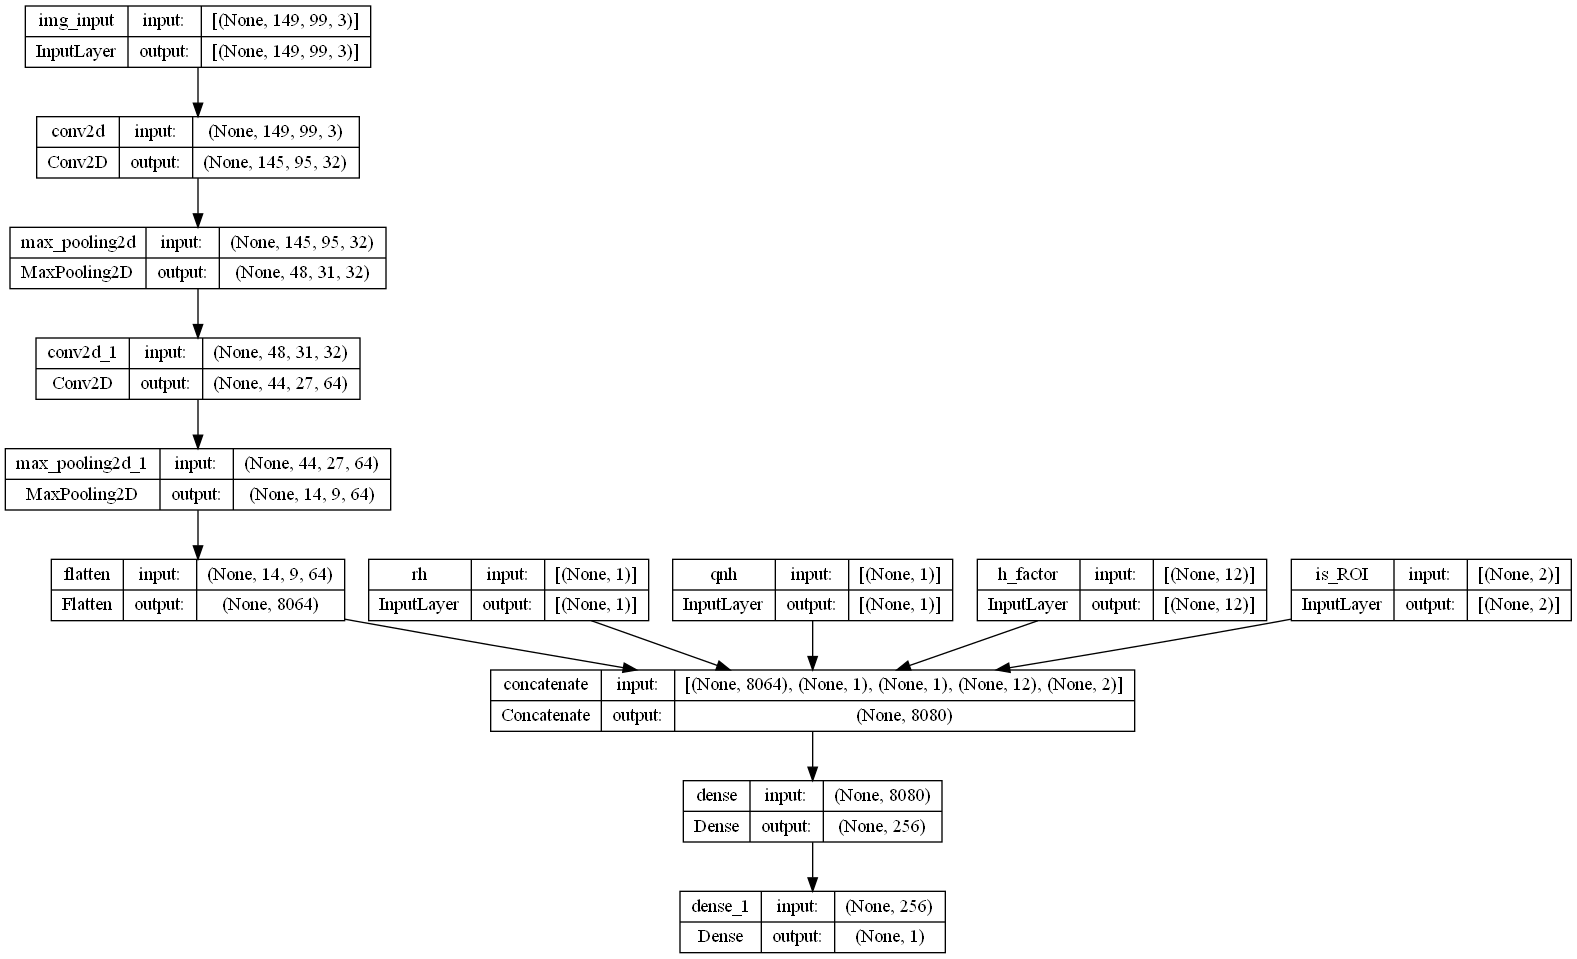

In [11]:
#Plot the structure of whole model
plot_model(model3, show_shapes=True, show_layer_names=True)

In [12]:
history3 = model3.fit(x=[img_list_train, df['rh'], df['qnh_normalised'], h_factor, is_ROI],
                      y=df["cloud_height"],
                      batch_size=8,
                      epochs=8,
                      verbose=1,
                      validation_split=0.2)

Epoch 1/8
34/34 [==============================] - 4s 81ms/step - loss: 9260.7129 - val_loss: 5130.3604
Epoch 2/8
34/34 [==============================] - 3s 85ms/step - loss: 7747.1294 - val_loss: 4608.5312
Epoch 3/8
34/34 [==============================] - 3s 81ms/step - loss: 6555.9282 - val_loss: 3695.9597
Epoch 4/8
34/34 [==============================] - 2s 71ms/step - loss: 4605.9126 - val_loss: 2894.5681
Epoch 5/8
34/34 [==============================] - 3s 78ms/step - loss: 3649.4697 - val_loss: 2825.0396
Epoch 6/8
34/34 [==============================] - 3s 78ms/step - loss: 3668.0806 - val_loss: 2632.8457
Epoch 7/8
34/34 [==============================] - 3s 78ms/step - loss: 3542.6550 - val_loss: 2716.8459
Epoch 8/8
34/34 [==============================] - 3s 81ms/step - loss: 3597.2246 - val_loss: 3323.0452


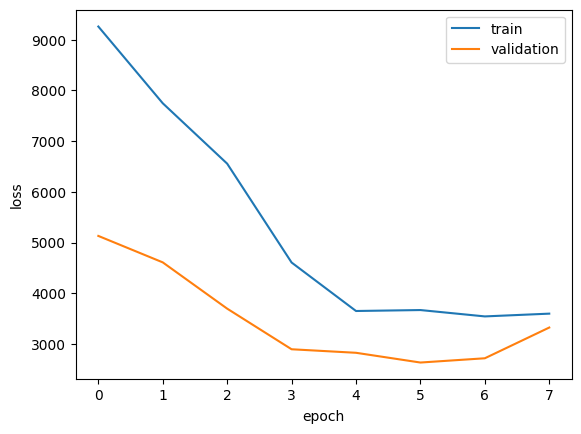

In [13]:
regression_history_plot(history3)

In [14]:
#Evaluate the regression model on test data
#Data preparation

#Preprecessing of three features
df_test['rh'] = rh_calculator(df_test['t_amb'],df_test['t_dew'])
df_test['qnh_normalised'] = normalise_1D_array(df_test['qnh'])
h_factor_test = (df_test['hh_z']-4).abs() #GMT time to CST, minus 12, and take abs. value to represent light intensity. Assume 12pm is the brightest hour.

#Convert h_factor and is_ROI to categorical variable
h_factor_test = to_categorical(h_factor_test,num_classes=12) #turn numeric value to one-hot code

is_ROI_test = label_encoder.fit_transform(df_test['is_ROI_pred']) #turn str to label
is_ROI_test = to_categorical(is_ROI_test,num_classes=2) #then turn label to one_hot code

#Make predictions using model trained
start_time = time.time()
pred = model3.predict(x=[img_list_test,df_test['rh'],df_test['qnh_normalised'],h_factor_test,is_ROI_test],
                      batch_size=8,
                      verbose=1)
cloud_height_pred = pred.flatten().astype(int) #remove fractions
end_time = time.time()
t_diff2 = end_time - start_time


print(f"It takes {t_diff1+t_diff2} seconds to complete SVM + multivariate CNN predictions")
#write the predicted values into a csv file
df_pred_result3 = pd.DataFrame({"window_name":df_test['window_name'], "y_pred":cloud_height_pred, "y_true":df_test["cloud_height"]})
df_pred_result3.to_csv(os.path.join(test_folder,"predicts3.csv"))

23/23 [==============================] - 0s 11ms/step
It takes 3.4233617782592773 seconds to complete SVM + multivariate CNN predictions


The Mean square error of model 3 is 4104.978
Check the 10 largest error are 
                  window_name  y_pred  y_true  pred_error
164           6-IR-N_1_0.jpg     179      25         154
148          21-IR-N_1_2.jpg     161      25         136
142          21-IR-N_0_4.jpg     156      25         131
177           6-IR-N_2_7.jpg      71     200         129
154          21-IR-N_2_3.jpg     152      25         127
68   1310-HDR_normal_2_4.jpg      73     200         127
151          21-IR-N_1_5.jpg      74     200         126
59   1310-HDR_normal_1_3.jpg      77     200         123
67   1310-HDR_normal_2_3.jpg      78     200         122
171           6-IR-N_1_7.jpg      78     200         122


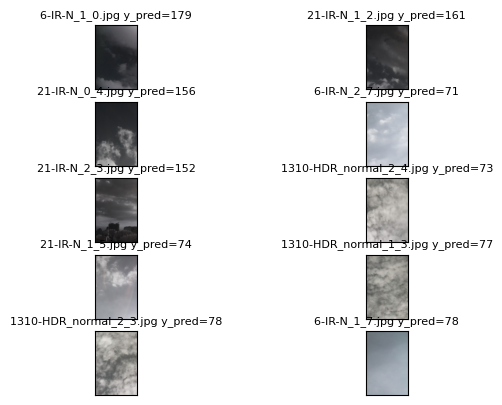

'\nMSE = 4527   (mean error approximate 67)\nAlthough environmental factors were incoporated , the model is still not good enough.\n\nAfter a quick inspect on predicted results, it can be said that the performence has improved!\n'

In [19]:
#Examinate the perforence of model3

#1. calculate MSE
model3_mse = np.square(np.subtract(df_pred_result3['y_true'],df_pred_result3['y_pred'])).mean() #MSE = (1/n)*Sigma(y_true-y_pred)^2
print(f'The Mean square error of model 3 is {round(model3_mse,3)}')

#2. check 10 images of largest prediction error
df_pred_result3['pred_error'] = np.subtract(df_pred_result3['y_true'],df_pred_result3['y_pred']).abs()
df_pred_result3.sort_values("pred_error",axis = 0, ascending =False, inplace =True)
print("Check the 10 largest error are \n",df_pred_result3[0:10])

index = df_pred_result3.index
for i in range(10):
    j = index[i]
    img = cv2.imread(os.path.join(test_folder,df_pred_result3['window_name'][j]))
    plt.subplot(5,2,i+1)
    plt.imshow(img)
    plt.title(df_pred_result3['window_name'][j]+" y_pred="+str(df_pred_result3['y_pred'][j]),fontsize=8)
    plt.xticks([])
    plt.yticks([])
plt.show()

'''
MSE = 4527   (mean error approximate 67)
Although environmental factors were incoporated , the model is still not good enough.

After a quick inspect on predicted results, it can be said that the performence has improved!
'''